# Tutorial Replication

The purpose of this notebook is simply to replicate Matt's tutorial, which can be found [on Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Sessions/List.aspx#folderID=%2265406b5e-52ef-428d-94d9-af6601597a08%22) in [two](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=c057cf3a-b1bd-4f85-a0e2-af66015ed850) [parts](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=b2e63522-720c-48e4-956a-af6901740c79). This will help us get an idea of how the syntax differs between pure ROOT and the Jupyter kernel implementation.

## Library Imports

In [1]:
import uproot
import glob
import math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
#%matplotlib inline

## Import Data
We also print the length of the first tree and its keys to ensure that data imported correctly.

(161790, 301)
['DetType', 'Empty', 'PAINTall', 'PAOFamps', 'PAOFamps0', 'PAOFchisq', 'PAOFchisqLF', 'PAOFdelay', 'PATFPamp', 'PATFPchisq', 'PATFPeflag', 'PATFPint', 'PATFPoffset', 'PATFPtau', 'PAWKf20', 'PAWKf40', 'PAWKf80', 'PAWKf90', 'PAWKf95', 'PAWKmax', 'PAWKr10', 'PAWKr100', 'PAWKr20', 'PAWKr30', 'PAWKr40', 'PAWKr50', 'PAWKr60', 'PAWKr70', 'PAWKr80', 'PAWKr90', 'PAWKr95', 'PAbias', 'PAbs', 'PAbspost', 'PAgain', 'PAnorm', 'PAsat', 'PAstd', 'PBINTall', 'PBOFamps', 'PBOFamps0', 'PBOFchisq', 'PBOFchisqLF', 'PBOFdelay', 'PBTFPamp', 'PBTFPchisq', 'PBTFPeflag', 'PBTFPint', 'PBTFPoffset', 'PBTFPtau', 'PBWKf20', 'PBWKf40', 'PBWKf80', 'PBWKf90', 'PBWKf95', 'PBWKmax', 'PBWKr10', 'PBWKr100', 'PBWKr20', 'PBWKr30', 'PBWKr40', 'PBWKr50', 'PBWKr60', 'PBWKr70', 'PBWKr80', 'PBWKr90', 'PBWKr95', 'PBbias', 'PBbs', 'PBbspost', 'PBgain', 'PBnorm', 'PBsat', 'PBstd', 'PCINTall', 'PCOFamps', 'PCOFamps0', 'PCOFchisq', 'PCOFchisqLF', 'PCOFdelay', 'PCTFPamp', 'PCTFPchisq', 'PCTFPeflag', 'PCTFPint', 'PCTFPoff

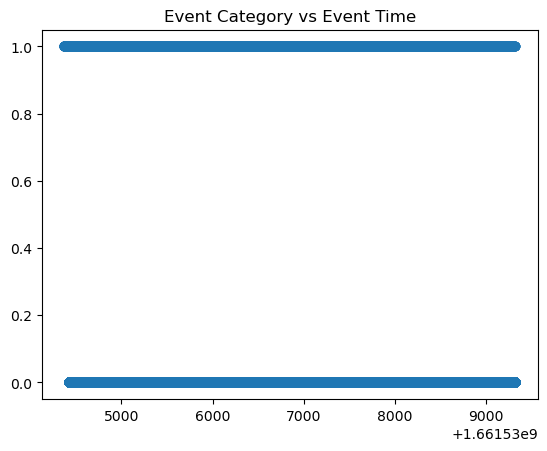

In [2]:
datapath ="R76Data/"
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"]
#As a Chain is a collection of Trees, 
#I am approximating the chain as a list of Trees.
nser = 6; e = []; z = [];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
#friends are complicated. here's the docs page on tchain friends: 
#https://root.cern/doc/master/classTChain.html#a967c9e4e14e314b46e4c11bc6a1c2353
#I think this is a reasonable approximation of them
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

print(z[0].shape)
print(list(z[0]))

plt.scatter(z[1]['EventTime'],z[1]['EventCategory'])
plt.title("Event Category vs Event Time")
plt.show()

Events have two categories; random (1) or triggered (0). Random events are taken so that we can perform diagnostics, but they aren't of any physical interest. 
Here, we are plotting them against the time they were taken. Above, we can't really see the points, so we will make a second plot that is zoomed in on the x-axis
(and has timestamp formatting).

## Basic Plotting

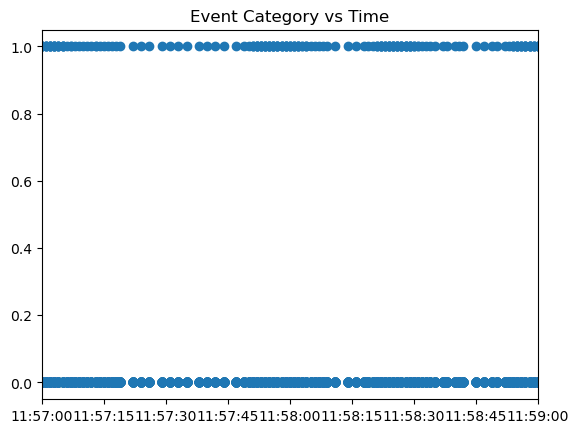

In [3]:
timestamps = [dt.datetime.fromtimestamp(x) for x in z[1]['EventTime'].values]
plt.scatter(timestamps,z[1]['EventCategory'])

#plt.xlim(dt.datetime(2020,8,26,11,56).timestamp(),dt.datetime(2020,8,26,12,00).timestamp())
#plt.xlim(pd.to_datetime("2020-08-26 11:56"),pd.to_datetime("2020-08-26 12:00"))

plt.xlim(pd.to_datetime("2022-08-26 11:57"),pd.to_datetime("2022-08-26 11:59"))
plt.title("Event Category vs Time")
plt.show()

Here are some "aliases" that define various values we may be referring back to often.
Unlike in ROOT, these "aliases" are calculated here once, nto recalculated each time they are called.
While it is unlikely that these would need to be recalculated due to some change in an underlying variable,
if they do, you will have to rerun this cell (or similar code in another cell) as it will not happen automatically.

In [4]:
#I don't see a better way to handle the aliases than to simply add a pandas column.
#Unfortunately this means that we will have to rerun this cell if anything the aliases depends on changes.
for x in z:
    x['PTwid'] = (x['PTWKf40'] - x['PTWKr40'])*1e6
    x['xdel'] = 1e6*(x['PEWKr20'] - 0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel'] = 1e6*(0.866*(x['PDWKr20'] - x['PCWKr20']))+9
    x['phidel'] = [180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['afdel'] = 1e6*(x['PFWKr20']-x['PAWKr20'])

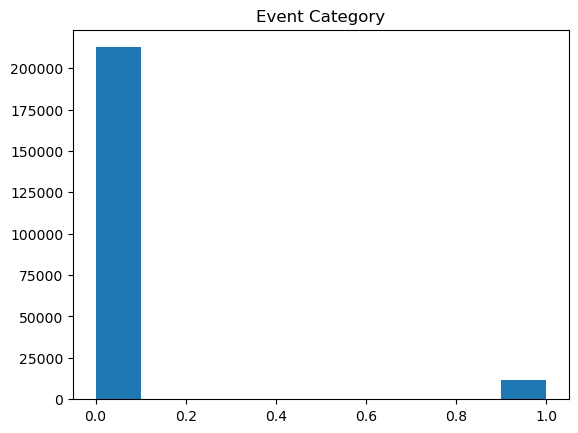

In [5]:
plt.hist(z[1]['EventCategory'])
plt.title("Event Category")
plt.show()

## Cuts
Now we will experiment with cuts. Cuts are built similarly to the aliases above. 
They are always boolean instead of providing numeric values; their purpose is to limit what data we are displaying and fitting to.
(There are also some "regular" aliases in the cell below as they are needed later.)

In [6]:
nentries = np.zeros(10); timestart = np.zeros(10); timeend = np.zeros(10);
crand = []; ctime0 = []; cam = []; cgoodwalk = [];
for i,x in enumerate(z):
    nentries[i] = x.shape[0]
    timestart[i] = e[i]['EventTime'].array[1000]
    timeend[i] = e[i]['EventTime'].array[-1]
    crand.append(z[i]['EventCategory']==1)
    ctime0.append(z[i].index > 60000)
    cam.append(z[i]['PFOFamps']/z[i]['PTOFamps']>0.21)
    cgoodwalk.append((z[i]['PCWKr20'] > 0.25e-3)
                     & (z[i]['PCWKr20']<0.5e-3)
                     & (z[i]['PDWKr20']>0.25e-3)
                     & (z[i]['PDWKr20']<0.5e-3)
                     & (z[i]['PEWKr20']>0.25e-3)
                     & (z[i]['PEWKr20']<0.5e-3))
timestart[0] = e[0]["EventTime"][60001]
timesec = timeend - timestart

161790 33685


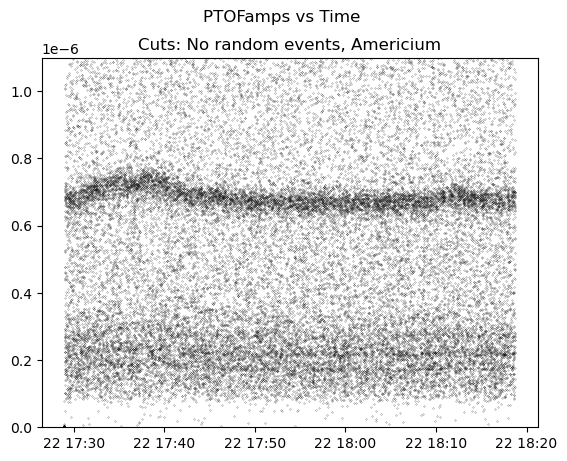

In [7]:
#print(len(~crand[0]),len(cam[0]))
print(len(z[0]['PTOFamps']),len(z[0]['PTOFamps'][~crand[0].array & cam[0]]))
timestamps = [dt.datetime.fromtimestamp(x) for x in z[0]['EventTime'].values[~crand[0] & cam[0]]]
plt.scatter(timestamps,z[0]['PTOFamps'][~crand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(0,1.1e-6)
plt.suptitle("PTOFamps vs Time")
plt.title("Cuts: No random events, Americium")
plt.show()

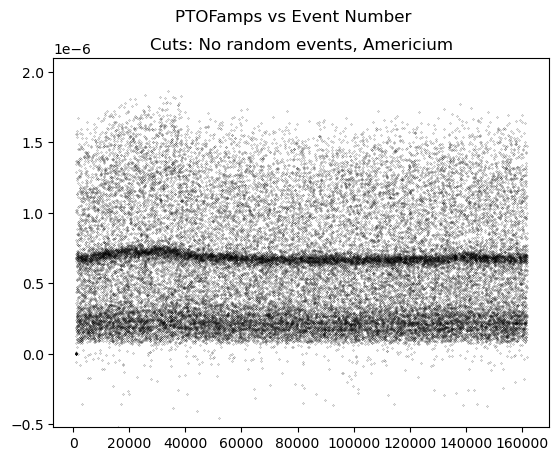

In [8]:
plt.scatter(z[0].index[~crand[0] & cam[0]],z[0]['PTOFamps'][~crand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(-0.52e-6,2.1e-6)
plt.suptitle("PTOFamps vs Event Number")
plt.title("Cuts: No random events, Americium")
#plt.xlim(0,180e3)
plt.show()

## Fitting

The below plot attempts to fit to one of the peaks present. After the plot are statistics on the fitting process.

200
20


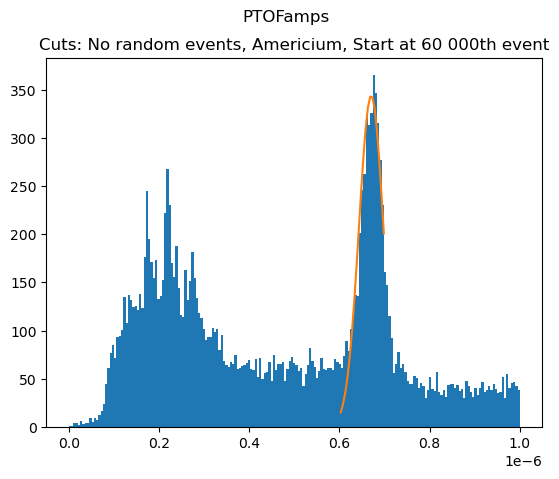

In [9]:
withcut = z[0]["PTOFamps"][~crand[0] & cam[0] & ctime0[0]]
bins = np.linspace(0,1e-6,200)
hspec0 = plt.hist(withcut,bins=bins)
def gauss(x,A=1,mu=0,sigma=1):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
subbins = bins[(bins >= 0.6e-6) & (bins <= 0.7e-6)]
print(len(hspec0[1]))
subdata = hspec0[0][(bins[:-1] >= 0.6e-6) & (bins[:-1] <= 0.7e-6)]
print(len(subdata))

gaussmod = lf.Model(gauss)
gaussparams = gaussmod.make_params(mu=0.675e-6)
gaussparams.add('sigma',value=1e-6,min=0)
gaussparams.add('A',value=1,min=0)
gaussfit = gaussmod.fit(subdata,gaussparams,weights=np.sqrt(subdata),x=subbins)

plt.plot(subbins,gaussfit.best_fit)
plt.suptitle("PTOFamps")
plt.title("Cuts: No random events, Americium, Start at 60 000th event")
plt.show()

gaussfit

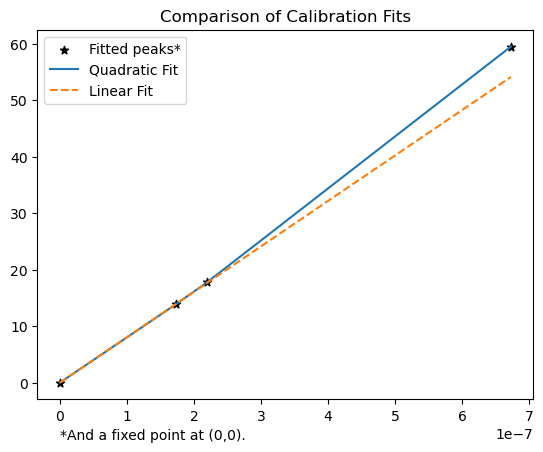

In [10]:
gcal = [[0,1.73263e-07,2.19449e-07,6.72661e-07],[0,13.95,17.74,59.54]]
plt.scatter(gcal[0],gcal[1],marker="*",color='k',label="Fitted peaks*")

def cal(x,a=1,b=1):
    return a*x+b*x**2

calmod = lf.Model(cal)
calparams = calmod.make_params()
calparams.add('a',value=60/7e-7,min=0)
calparams.add('b',value=1e20,min=0) #Start large to give it a push in the right direction
calfit = calmod.fit(gcal[1],calparams,x=gcal[0])

plt.plot(gcal[0],calfit.best_fit,label="Quadratic Fit")
plt.plot(gcal[0],13.95*np.asarray(gcal[0])/1.73263e-07,linestyle='--',label="Linear Fit")

plt.text(0,-10,"*And a fixed point at (0,0).")

plt.title("Comparison of Calibration Fits")
plt.legend()
plt.show()

calfit

## 2D Histograms
Many of the plots below are 2D-histograms that compare two parameters by creating a color-based histogram of frequencies.

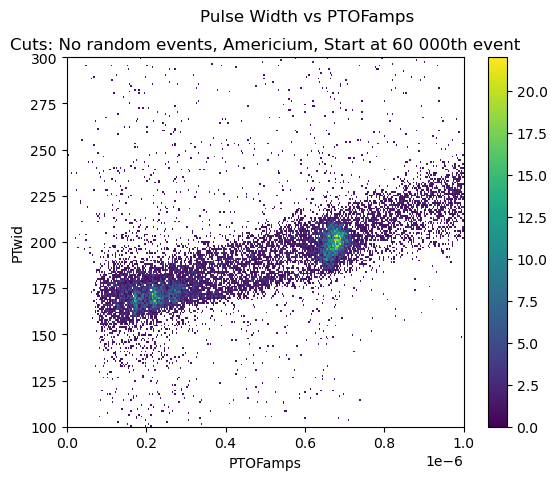

In [11]:
try:
    pt_keV[0] = calfit.best_values['a']*z[0]["PTOFamps"]+calfit.best_values['b']*z[0]["PTOFamps"]**2
except NameError:
    pt_keV = [calfit.best_values['a']*z[0]["PTOFamps"]+calfit.best_values['b']*z[0]["PTOFamps"]**2]

fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[0]["PTOFamps"][~crand[0] & cam[0] & ctime0[0]],
               z[0]["PTwid"][~crand[0] & cam[0] & ctime0[0]],
               bins=[np.linspace(0,1e-6,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.
    
plt.xlabel("PTOFamps")
plt.ylabel("PTwid")
plt.suptitle("Pulse Width vs PTOFamps")
plt.title("Cuts: No random events, Americium, Start at 60 000th event")
fig.colorbar(h[3])
plt.show() #Hard to tell if this is quite right... but it seems okay for now

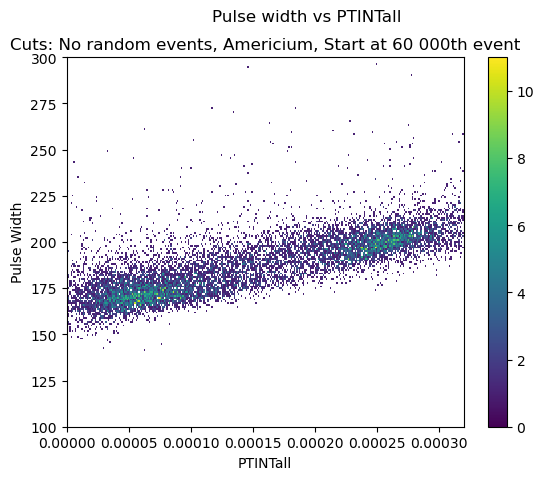

In [12]:
fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[0]["PTINTall"][~crand[0] & cam[0] & ctime0[0]],
               z[0]["PTwid"][~crand[0] & cam[0] & ctime0[0]],
               bins=[np.linspace(0,0.32e-3,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.

fig.colorbar(h[3])
plt.xlabel("PTINTall")
plt.ylabel("Pulse Width")
plt.suptitle("Pulse width vs PTINTall")
plt.title("Cuts: No random events, Americium, Start at 60 000th event")
plt.show()

Here is a new cut to try to get good events.

In [13]:
cgood = [];
cgood.append(ctime0[0])
for i,x in enumerate(z):
    if i>0:
        cgood.append(np.ones(x.shape[0]))

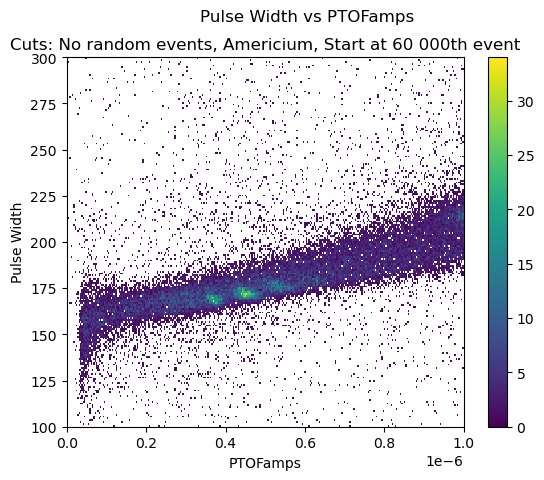

In [14]:
fig = plt.figure()

cmap = cm.viridis.copy()
cmap.set_under('w')

h = plt.hist2d(z[1]["PTOFamps"][~crand[1] & cam[1] & ctime0[1]],
               z[1]["PTwid"][~crand[1] & cam[1] & ctime0[1]],
               bins=[np.linspace(0,1e-6,300),np.linspace(100,300,200)],cmap=cmap,vmin=1e-10)
                #force white bg instead of purple to help comparison.

fig.colorbar(h[3])
plt.xlabel("PTOFamps")
plt.ylabel("Pulse Width")
plt.suptitle("Pulse Width vs PTOFamps")
plt.title("Cuts: No random events, Americium, Start at 60 000th event")
plt.show()

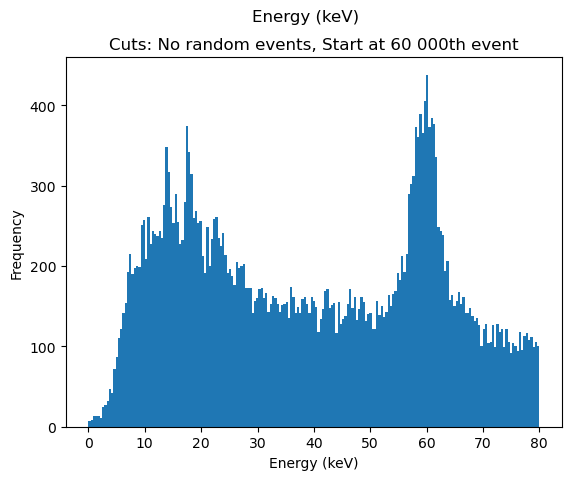

In [15]:
h0 = plt.hist(pt_keV[0][~crand[0] & ctime0[0]],bins=np.linspace(0,80,200))

plt.xlabel("Energy (keV)")
plt.ylabel("Frequency")
plt.suptitle("Energy (keV)")
plt.title("Cuts: No random events, Start at 60 000th event")
plt.show()

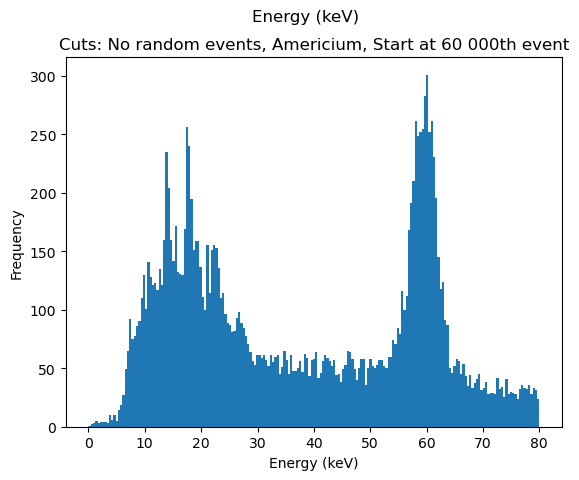

In [16]:
plt.hist(pt_keV[0][~crand[0] & ctime0[0] & cam[0]],bins=np.linspace(0,80,200))
plt.xlabel("Energy (keV)")
plt.ylabel("Frequency")
plt.suptitle("Energy (keV)")
plt.title("Cuts: No random events, Americium, Start at 60 000th event")
plt.show()

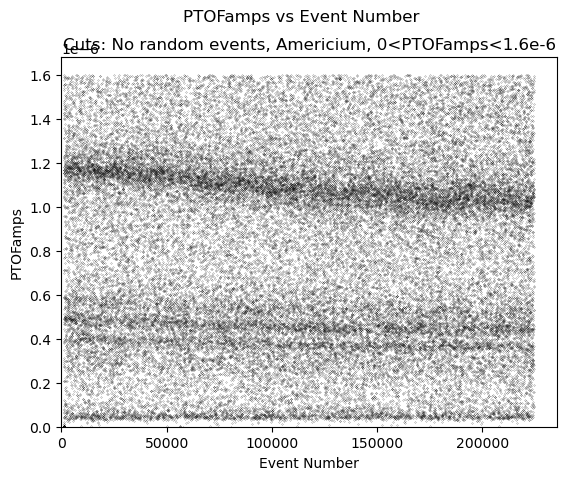

In [17]:
cam[1] = z[1]["PFOFamps"]/z[1]["PTOFamps"] > 0.26

plt.scatter(z[1].index[~crand[1] & cam[1] & (z[1]["PTOFamps"] > 0) & (z[1]["PTOFamps"] < 1.6e-6)],
            z[1]["PTOFamps"][~crand[1] & cam[1] & (z[1]["PTOFamps"] > 0) & (z[1]["PTOFamps"] < 1.6e-6)],
            s=0.02,color='k')

plt.xlabel("Event Number")
plt.ylabel("PTOFamps")
plt.suptitle("PTOFamps vs Event Number")
plt.title("Cuts: No random events, Americium, 0<PTOFamps<1.6e-6") #note: for plotting alone, this last cut could easily be done by simply adjusting the plot limits
plt.ylim(0); plt.xlim(0)
plt.show()

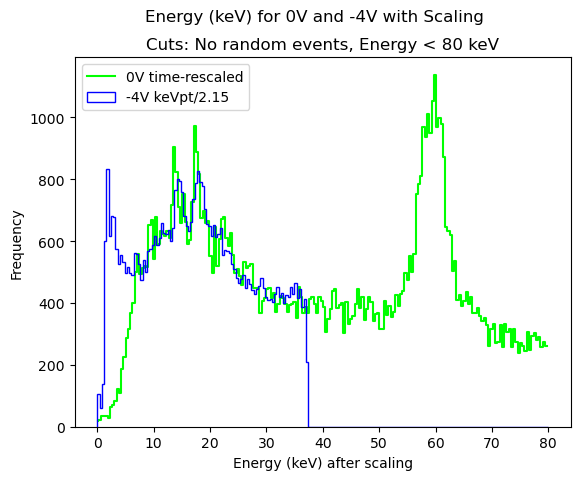

In [18]:
try:
    pt_keV[1] = 7.73882e+07*z[1]["PTOFamps"]+1.653756e+13*z[1]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.73882e+07*z[1]["PTOFamps"]+1.653756e+13*z[1]["PTOFamps"]**2)

plt.step((h0[1][:-1]+h0[1][1:])/2,h0[0]*timesec[1]/timesec[0],color='lime',label="0V time-rescaled")
h1 = plt.hist(np.asarray(pt_keV[1])[(np.asarray(pt_keV[1])<80) & ~crand[1]]/2.15,
         bins=np.linspace(0,80,200),histtype='step',color='blue',label="-4V keVpt/2.15")#,linewidth=2)
plt.legend()
plt.xlabel("Energy (keV) after scaling")
plt.ylabel("Frequency")
plt.suptitle("Energy (keV) for 0V and -4V with Scaling")
plt.title("Cuts: No random events, Energy < 80 keV")
plt.show()

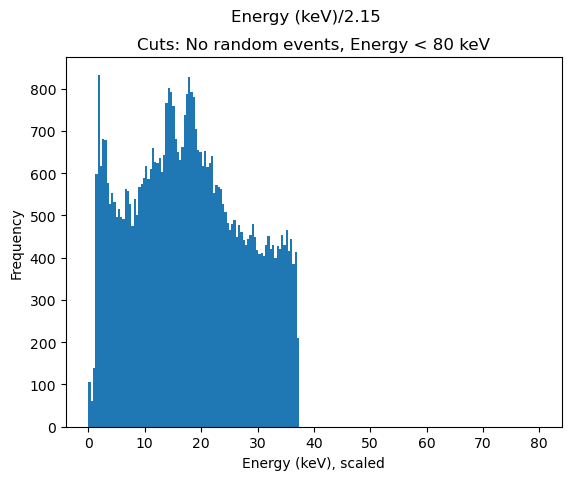

In [19]:
plt.hist(pt_keV[1][~crand[1] & (pt_keV[1]<80)]/2.15,bins=np.linspace(0,80,200))
plt.xlabel("Energy (keV), scaled")
plt.ylabel("Frequency")
plt.suptitle("Energy (keV_ee)")
plt.title("Cuts: No random events, Energy < 80 keV")
plt.show()

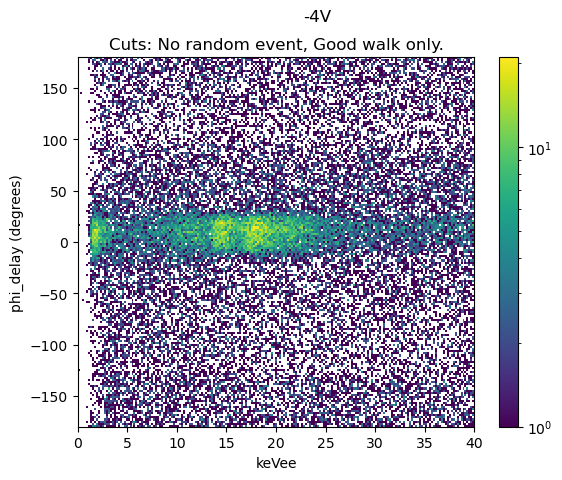

In [21]:
fig = plt.figure()
h = plt.hist2d(pt_keV[1][~crand[1] & cgoodwalk[1]]/2.15,
               z[1]["phidel"][~crand[1] & cgoodwalk[1]],
               bins=[np.linspace(0,40,200),np.linspace(-180,180,180)],
               cmap=cmap,norm=colors.LogNorm())
               #force white bg instead of purple to help comparison.
    
plt.suptitle("-4V")
plt.xlabel("keVee")
plt.ylabel("phi_delay (degrees)")
plt.title("Cuts: No random event, Good walk only.")
fig.colorbar(h[3])
plt.show()

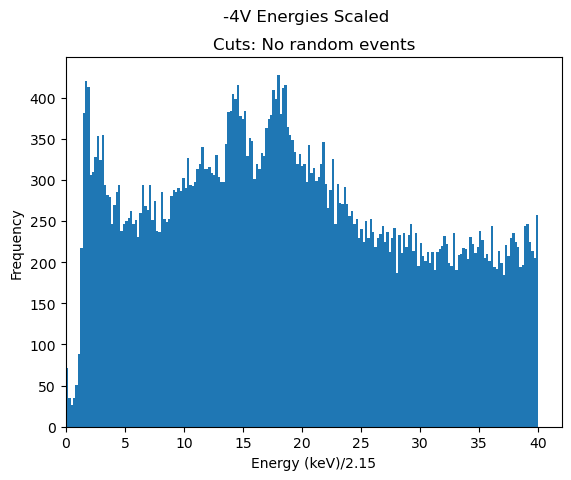

In [23]:
plt.hist(pt_keV[1][~crand[1]]/2.15,bins=np.linspace(0,40,200))
plt.xlim(0)
plt.xlabel("Energy (keV_ee)")
plt.ylabel("Frequency")
plt.title("Cuts: No random events")
plt.suptitle("-4V Energies Scaled")
plt.show()

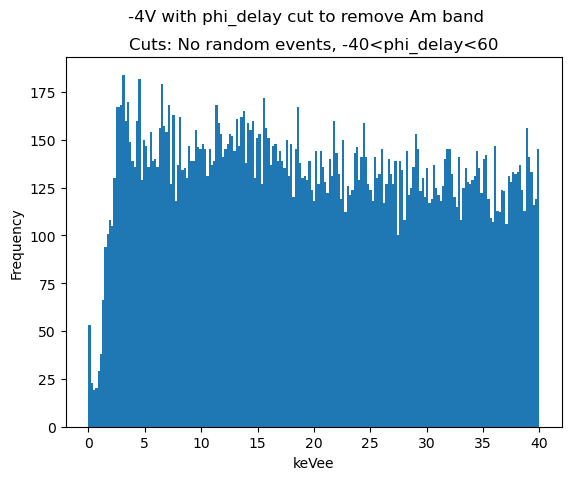

In [24]:
plt.hist(pt_keV[1][~crand[1] & ~((z[1]["phidel"]>-40) & (z[1]["phidel"]<60))]/2.15,bins=np.linspace(0,40,200))
plt.suptitle("-4V with phi_delay cut to remove Am band")
plt.xlabel("keVee")
plt.ylabel("Frequency")
plt.title("Cuts: No random events, -40<phi_delay<60")
plt.show()

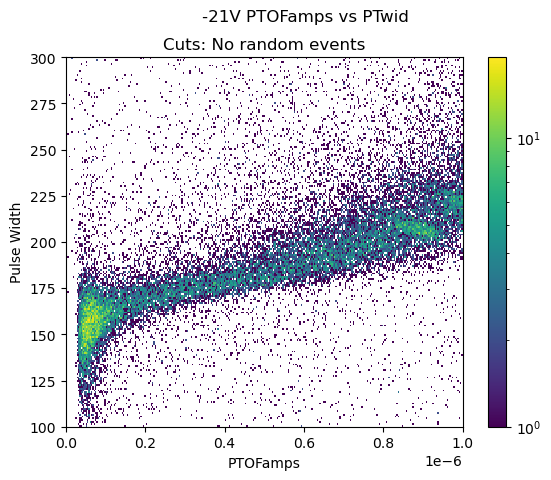

In [27]:
fig = plt.figure()
h = plt.hist2d(z[2]["PTOFamps"][~crand[2]],z[2]["PTwid"][~crand[2]],
           bins=(np.linspace(0,1e-6,300),np.linspace(100,300,200)),cmap=cmap,norm=colors.LogNorm())
plt.xlabel("PTOFamps")
plt.ylabel("Pulse Width")
plt.title("Cuts: No random events")
plt.suptitle(lab[2]+" PTOFamps vs PTwid")
fig.colorbar(h[3])
plt.show()

The try/except cases below are designed to make the code a bit more robust when run out of order.

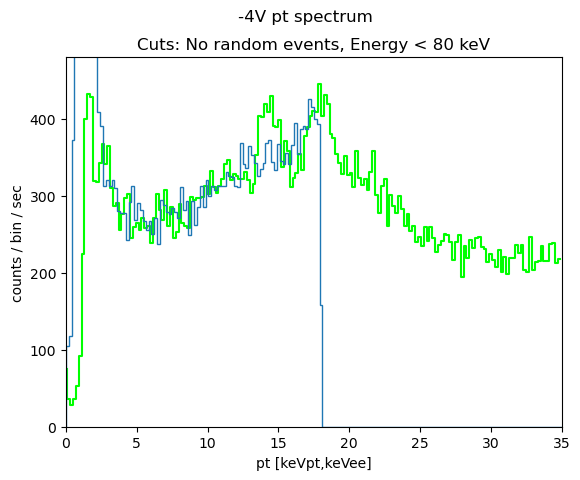

In [28]:
try:
    pt_keV[2] = 7.738820e+07*z[2]["PTOFamps"]+1.653756e+13*z[2]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.738820e+07*z[2]["PTOFamps"]+1.653756e+13*z[2]["PTOFamps"]**2)
try:
    pt0_keV[2] = 7.738820e+07*z[2]["PTOFamps0"]+1.653756e+13*z[2]["PTOFamps0"]**2
except NameError:
    pt0_keV = [[],[],7.738820e+07*z[2]["PTOFamps0"]+1.653756e+13*z[2]["PTOFamps0"]**2]

h1 = np.histogram(pt_keV[1][~crand[1]]/2.15,bins=np.linspace(0,35,175));
fig = plt.figure()
    
plt.step((h1[1][:-1]+h1[1][1:])/2,h1[0]*timesec[2]/timesec[1],color='lime',label="-4V keVpt/2.15 time-rescaled")
h2 = plt.hist(pt_keV[2][~crand[2] & (pt_keV[2]<80)]/4.45,bins=np.linspace(0,35,175),histtype='step')

plt.suptitle("-4V pt spectrum")
plt.title("Cuts: No random events, Energy < 80 keV")
plt.xlabel("pt [keVpt,keVee]");plt.ylabel("counts / bin / sec")
plt.xlim(0,35);plt.ylim(0,480)
plt.show()

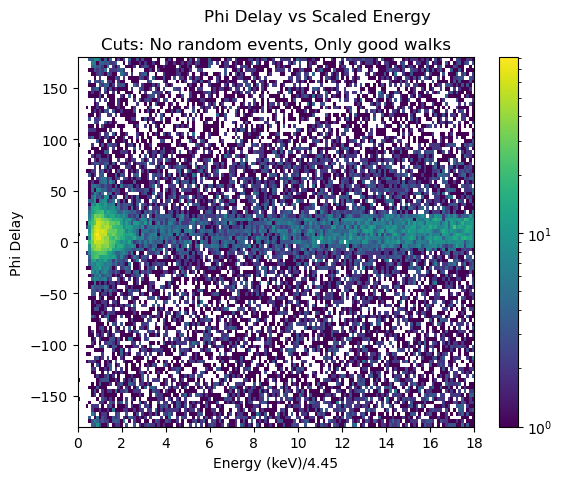

In [30]:
fig = plt.figure()
h = plt.hist2d(pt_keV[2][~crand[2] & cgoodwalk[2]]/4.45,z[2]["phidel"][~crand[2] & cgoodwalk[2]],
           bins=(np.linspace(0,18,150),np.linspace(-180,180,100)),norm=colors.LogNorm())
fig.colorbar(h[3])
plt.xlabel("Energy (keV)/4.45")
plt.ylabel("Phi Delay")
plt.suptitle("Phi Delay vs Scaled Energy")
plt.title("Cuts: No random events, Only good walks")
plt.show()

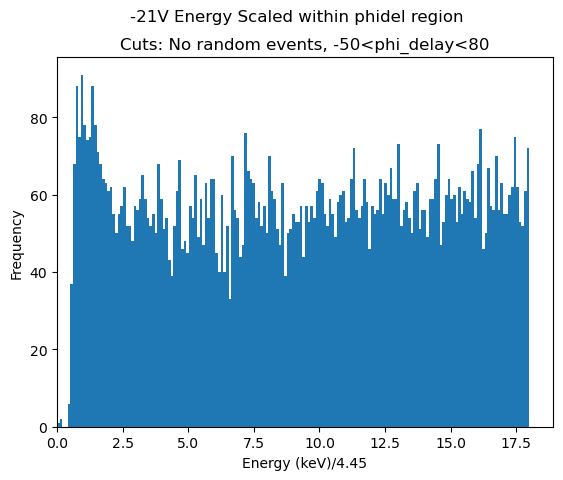

In [31]:
plt.hist(pt_keV[2][~crand[2] & ~((z[2]["phidel"]>-50)&(z[2]["phidel"]<80)) & cgoodwalk[2]]/4.45,
         bins=np.linspace(0,18,180))
plt.xlim(0)
plt.xlabel("Energy (keV)/4.45")
plt.ylabel("Frequency")
plt.suptitle(lab[2]+" Energy Scaled within phidel region")
plt.title("Cuts: No random events, -50<phi_delay<80")
plt.show()

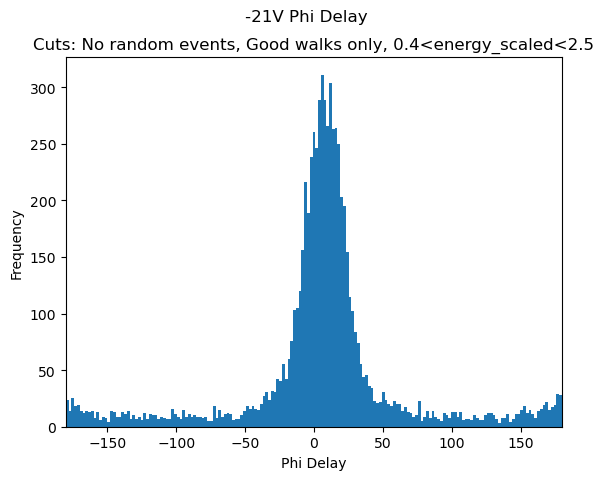

In [32]:
plt.hist(z[2]["phidel"][~crand[2] & cgoodwalk[2] & (pt_keV[2]/4.45 > 0.4) & (pt_keV[2]/4.15 < 2.5)],
         bins=np.linspace(-180,180,180))
plt.title("Cuts: No random events, Good walks only, 0.4<energy_scaled<2.5")
plt.suptitle(lab[2]+" Phi Delay")
plt.xlabel("Phi Delay")
plt.ylabel("Frequency")
plt.xlim(-180,180)
plt.show()

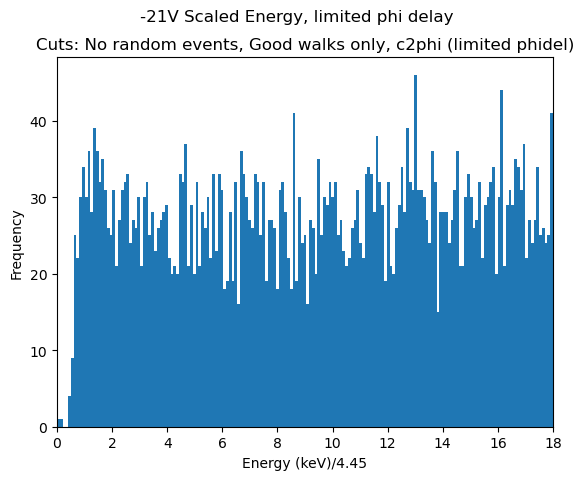

In [34]:
for x in z:
    x["c2phi"] = ((x["phidel"] > -160) & (x["phidel"] < -50)) | ((x["phidel"] > 70) & (x["phidel"] < 50))
    
plt.hist(pt_keV[2][~crand[2] & cgoodwalk[2] & z[2]["c2phi"]]/4.45,bins=np.linspace(0,18,180))
plt.xlim(0,18)
plt.xlabel("Energy (keV)/4.45")
plt.ylabel("Frequency")
plt.title("Cuts: No random events, Good walks only, c2phi (limited phidel)")
plt.suptitle(lab[2]+" Scaled Energy, limited phi delay")
plt.show()

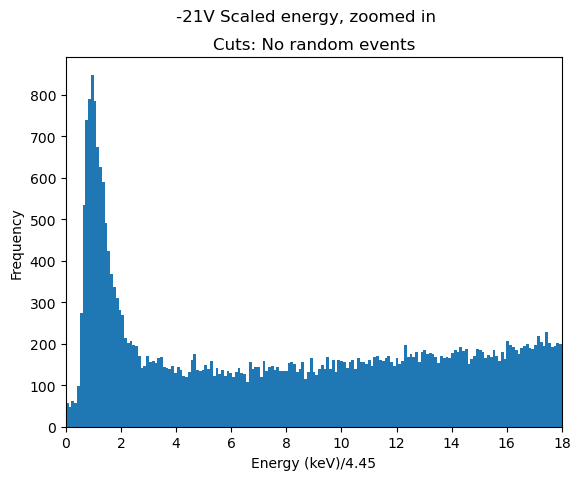

In [35]:
h2 = plt.hist(pt_keV[2][~crand[2]]/4.45,bins=np.linspace(0,18,180))
plt.xlim(0,18)
plt.xlabel("Energy (keV)/4.45")
plt.ylabel("Frequency")
plt.title("Cuts: No random events")
plt.suptitle(lab[2]+" Scaled energy, zoomed in")
plt.show()

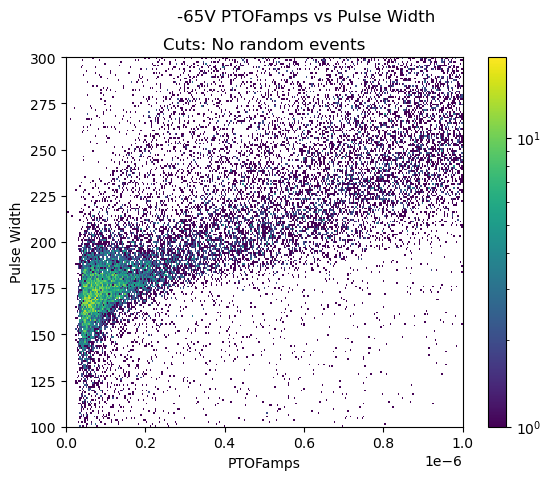

In [36]:
fig = plt.figure()
h = plt.hist2d(z[3]["PTOFamps"][~crand[3]],z[3]["PTwid"][~crand[3]],
           bins=(np.linspace(0,1e-6,300),np.linspace(100,300,200)),norm=colors.LogNorm())
fig.colorbar(h[3])
plt.title("Cuts: No random events")
plt.xlabel("PTOFamps")
plt.ylabel("Pulse Width")
plt.suptitle(lab[3]+" PTOFamps vs Pulse Width")
plt.show()

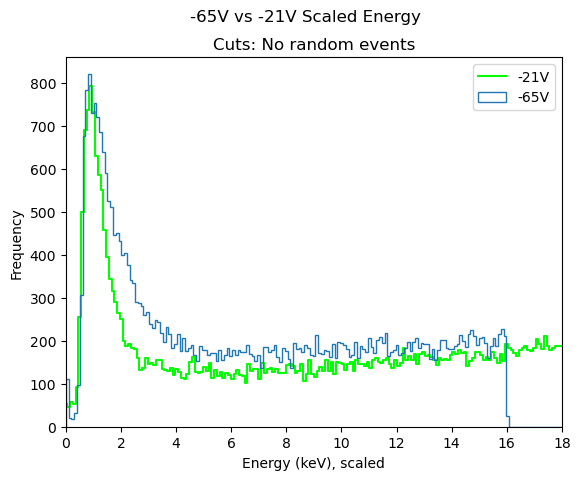

In [38]:
try:
    pt_keV[3] = 7.738820e+07*z[3]["PTOFamps"]+1.653756e+13*z[3]["PTOFamps"]**2
except IndexError:
    pt_keV.append(7.738820e+07*z[3]["PTOFamps"]+1.653756e+13*z[3]["PTOFamps"]**2)
try:
    pt0_keV[3] = 7.738820e+07*z[3]["PTOFamps0"]+1.653756e+13*z[3]["PTOFamps0"]**2
except IndexError:
    pt0_keV.append(7.738820e+07*z[3]["PTOFamps0"]+1.653756e+13*z[3]["PTOFamps0"]**2)

plt.step((h2[1][:-1]+h2[1][1:])/2,h2[0]*timesec[3]/timesec[2],color='lime',label=lab[2])
h3 = plt.hist(pt_keV[3][~crand[3] & (pt_keV[3]<80)]/5,bins=np.linspace(0,18,180),histtype='step',label=lab[3])
plt.xlim(0,18); plt.ylim(0,860)
plt.xlabel("Energy (keV), scaled")
plt.ylabel("Frequency")
plt.title("Cuts: No random events")
plt.suptitle(lab[3]+" vs "+lab[2]+" Scaled Energy")
plt.legend()
plt.show()

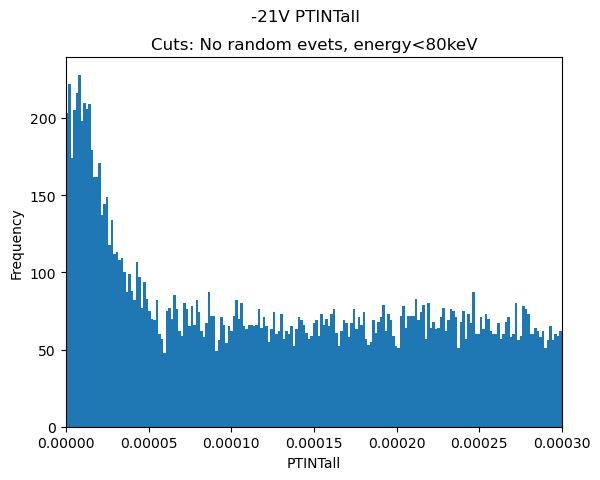

In [39]:
h2i = plt.hist(z[2]["PTINTall"][~crand[2] & (pt_keV[2]<80)],bins=np.linspace(0,0.0003,200))
plt.xlim(0,0.0003)
plt.title("Cuts: No random evets, energy<80keV")
plt.xlabel("PTINTall"); plt.ylabel("Frequency")
plt.suptitle(lab[2]+" PTINTall")
plt.show()

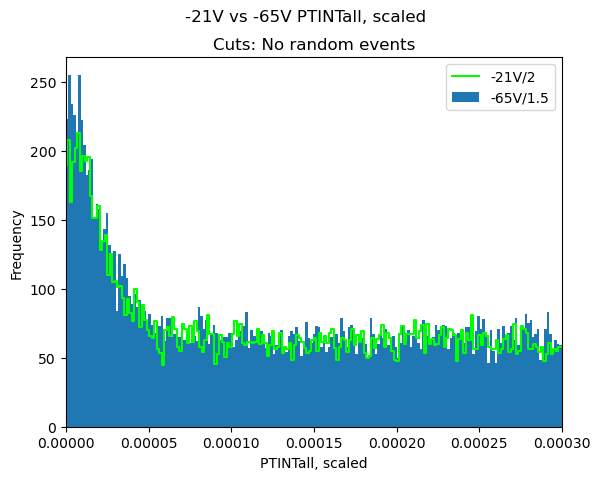

In [40]:
plt.step((h2i[1][:-1]+h2i[1][1:])/2,h2i[0]*timesec[3]/timesec[2],color='lime',label=lab[2]+"/2")
plt.hist(z[3]["PTINTall"][~crand[3]]/1.5,bins=np.linspace(0,0.0003,200),label=lab[3]+"/1.5")
plt.suptitle(lab[2]+" vs "+lab[3]+" PTINTall, scaled")
plt.title("Cuts: No random events")
plt.xlabel("PTINTall, scaled")
plt.ylabel("Frequency")
plt.legend()

plt.xlim(0,0.0003)
plt.show()

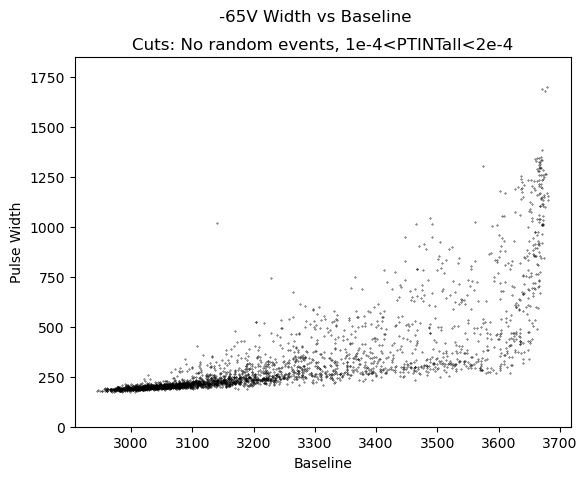

In [41]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
            z[3]["PTwid"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.1,color='k')
plt.ylim(0,1850)
plt.xlabel("Baseline"); plt.ylabel("Pulse Width")
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.suptitle(lab[3]+" Width vs Baseline")
plt.show()

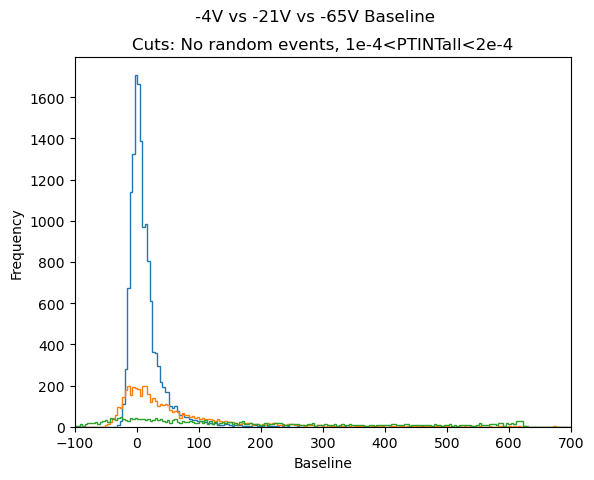

In [42]:
h1bs = plt.hist(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] - 3026,
         bins = np.linspace(-100,700,200),histtype="step")
h2bs = plt.hist(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] - 2935,
         bins = np.linspace(-100,700,200),histtype="step")
h3bs = plt.hist(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] - 3050,
         bins = np.linspace(-100,700,200),histtype="step")
plt.suptitle(lab[1]+" vs "+lab[2]+" vs "+lab[3]+" Baseline")
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.xlabel("Baseline"); plt.ylabel("Frequency")
plt.xlim(-100,700)
plt.show()

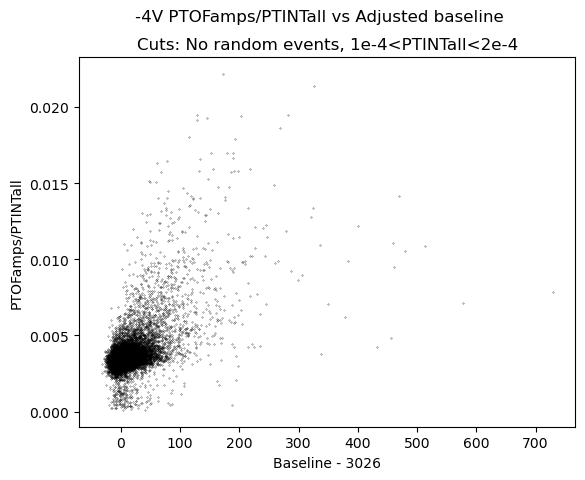

In [43]:
plt.scatter(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] - 3026, 
            z[1]["PTOFamps"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)]/z[1]["PTINTall"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.xlabel("Baseline - 3026"); plt.ylabel("PTOFamps/PTINTall")
plt.suptitle(lab[1]+" PTOFamps/PTINTall vs Adjusted baseline")
plt.show()

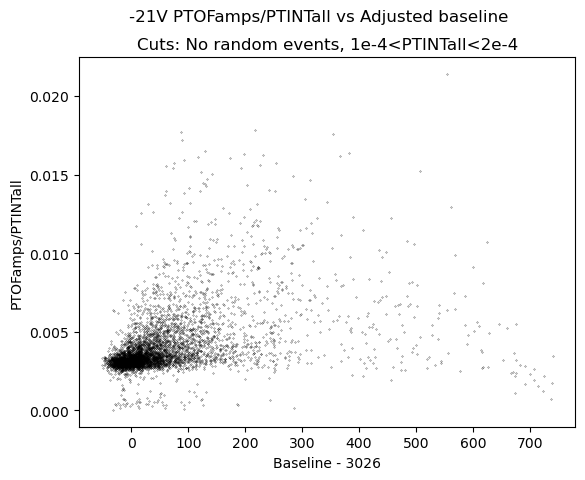

In [44]:
plt.scatter(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] - 2935, 
            z[2]["PTOFamps"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)]/z[2]["PTINTall"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.xlabel("Baseline - 3026"); plt.ylabel("PTOFamps/PTINTall")
plt.suptitle(lab[2]+" PTOFamps/PTINTall vs Adjusted baseline")
plt.show()

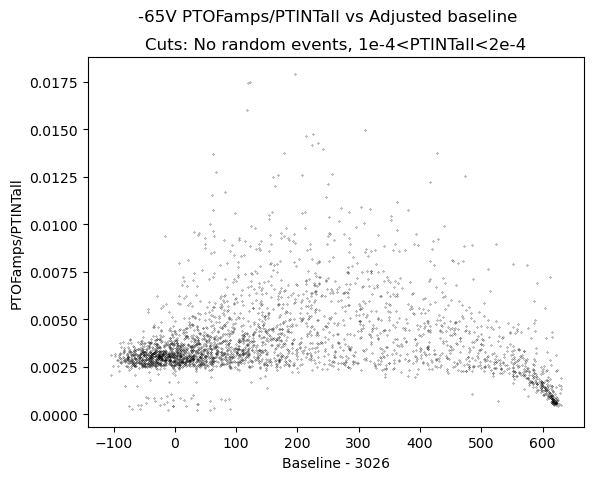

In [45]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] - 3050, 
            z[3]["PTOFamps"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)]/z[3]["PTINTall"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.xlabel("Baseline - 3026"); plt.ylabel("PTOFamps/PTINTall")
plt.suptitle(lab[3]+" PTOFamps/PTINTall vs Adjusted baseline")
plt.show()

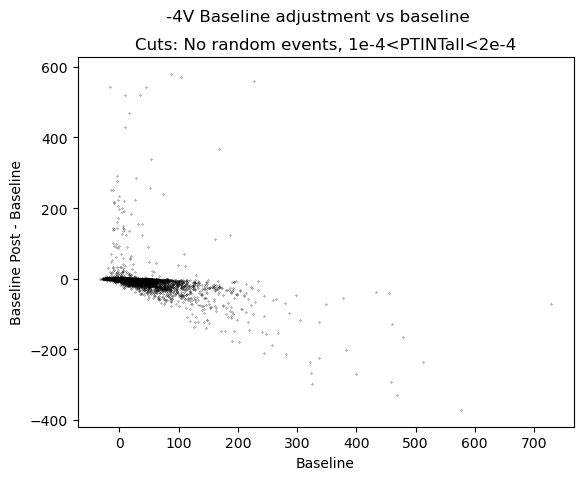

In [46]:
c3bs = z[3]["PFbs"] - 3050 < 540
plt.scatter(z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)]-3026,
            z[1]["PFbspost"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)] 
            - z[1]["PFbs"][~crand[1] & (z[1]["PTINTall"]>0.1e-3) & (z[1]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.xlabel("Baseline"); plt.ylabel("Baseline Post - Baseline")
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.suptitle(lab[1]+" Baseline adjustment vs baseline")
plt.show()

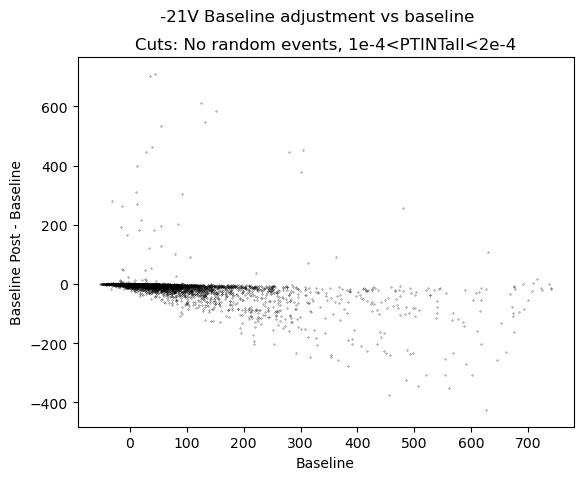

In [47]:
plt.scatter(z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)]-2935,
            z[2]["PFbspost"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)] 
            - z[2]["PFbs"][~crand[2] & (z[2]["PTINTall"]>0.1e-3) & (z[2]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.xlabel("Baseline"); plt.ylabel("Baseline Post - Baseline")
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.suptitle(lab[2]+" Baseline adjustment vs baseline")
plt.show()

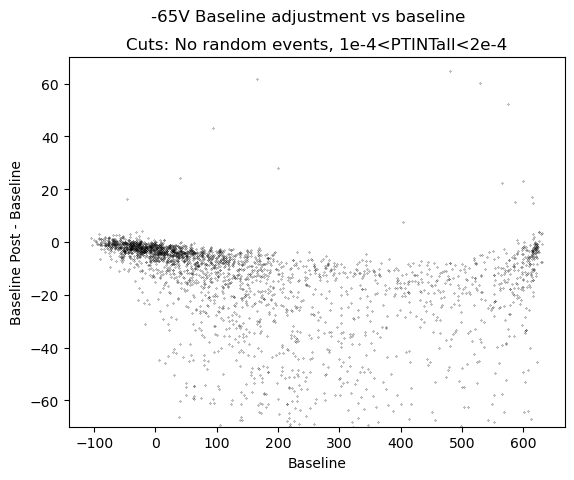

In [48]:
plt.scatter(z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)]-3050,
            z[3]["PFbspost"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)] 
            - z[3]["PFbs"][~crand[3] & (z[3]["PTINTall"]>0.1e-3) & (z[3]["PTINTall"]<0.2e-3)],
           s=0.05,color='k')
plt.xlabel("Baseline"); plt.ylabel("Baseline Post - Baseline")
plt.title("Cuts: No random events, 1e-4<PTINTall<2e-4")
plt.suptitle(lab[3]+" Baseline adjustment vs baseline")
plt.ylim(-70,70)
plt.show()

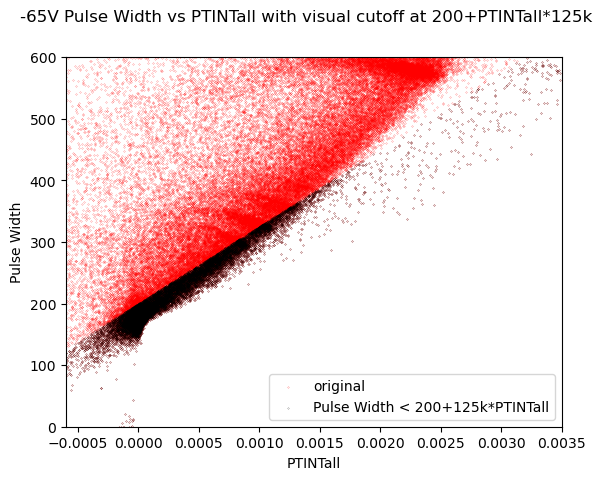

In [49]:
c2wid = z[2]["PTwid"]<180 + 125000*z[2]["PTINTall"]
c3wid = z[3]["PTwid"]<200 + 125000*z[3]["PTINTall"]
plt.scatter(z[3]["PTINTall"][~crand[3] & cgoodwalk[3]],z[3]["PTwid"][~crand[3] & cgoodwalk[3]],
           s=0.02,color='r',label='original')
plt.scatter(z[3]["PTINTall"][~crand[3] & cgoodwalk[3] & c3wid],
            z[3]["PTwid"][~crand[3] & cgoodwalk[3] & c3wid],s=0.02,color='k',label='Pulse Width < 200+125k*PTINTall')
plt.legend()
plt.suptitle(lab[3]+" Pulse Width vs PTINTall with visual cutoff at 200+PTINTall*125k")
plt.xlabel("PTINTall"); plt.ylabel("Pulse Width")
plt.ylim(0,600);plt.xlim(-0.0006,0.0035)
plt.show()

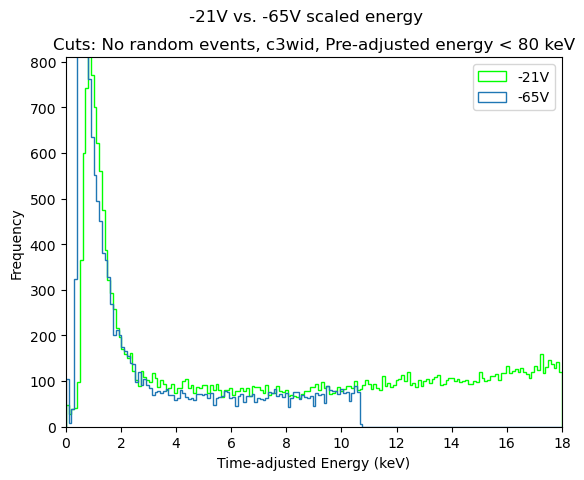

In [50]:
fig = plt.figure()

h2w = plt.hist(pt_keV[2][~crand[2] & c2wid]/4.45*timesec[3]/timesec[2],bins=np.linspace(0,18,180),
              color='lime',histtype='step',label=lab[2])
h3w = plt.hist(pt_keV[3][~crand[3] & c3wid & (pt_keV[3]<80)]/7.5,bins=np.linspace(0,18,180),histtype='step',label=lab[3])

plt.xlabel("Time-adjusted Energy (keV)"); plt.ylabel("Frequency")
plt.title("Cuts: No random events, c3wid, Pre-adjusted energy < 80 keV")
plt.suptitle(lab[2]+" vs. "+lab[3]+" scaled energy")

plt.legend()
plt.xlim(0,18);plt.ylim(0,810)
plt.show()

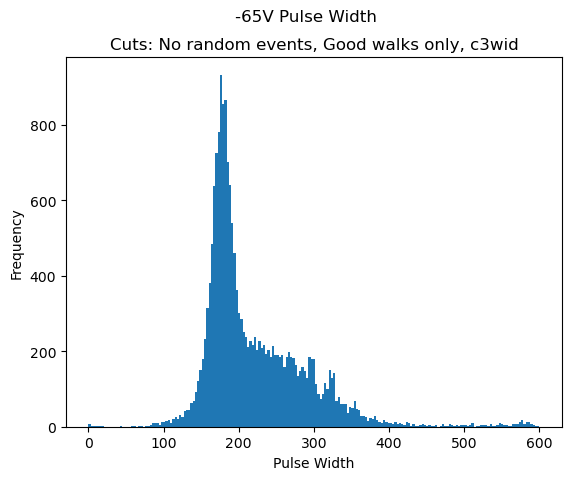

In [51]:
plt.hist(z[3]["PTwid"][~crand[3] & cgoodwalk[3] & c3wid],bins=np.linspace(0,600,200))
plt.title("Cuts: No random events, Good walks only, c3wid")
plt.suptitle(lab[3]+" Pulse Width")
plt.xlabel("Pulse Width"); plt.ylabel("Frequency")
plt.show()

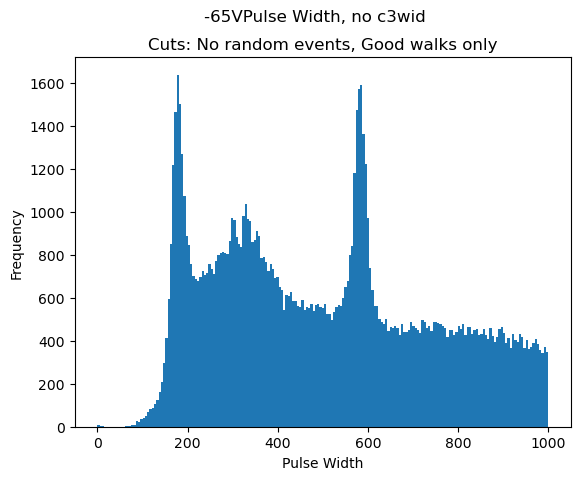

In [52]:
plt.hist(z[3]["PTwid"][~crand[3] & cgoodwalk[3]],bins=np.linspace(0,1000,200))
plt.suptitle(lab[3]+"Pulse Width, no c3wid")
plt.title("Cuts: No random events, Good walks only")
plt.xlabel("Pulse Width"); plt.ylabel("Frequency")
plt.show()

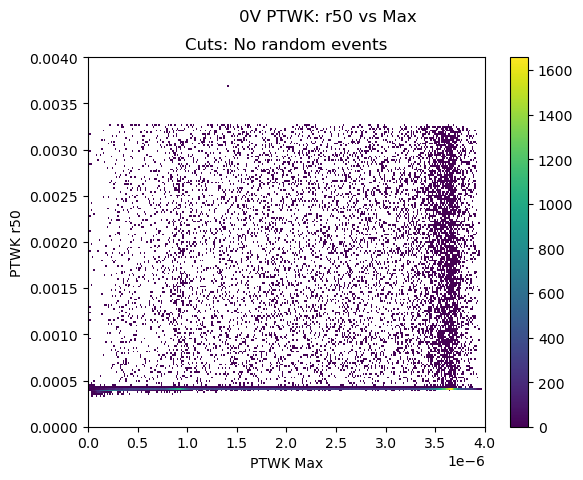

In [53]:
fig = plt.figure()
h = plt.hist2d(z[0]["PTWKmax"][~crand[0]],z[0]["PTWKr50"][~crand[0]],
           bins=(np.linspace(0,4e-6,300),np.linspace(0,0.004,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.xlabel("PTWK Max"); plt.ylabel("PTWK r50")
plt.title("Cuts: No random events")
plt.suptitle(lab[0]+" PTWK: r50 vs Max")
plt.show()

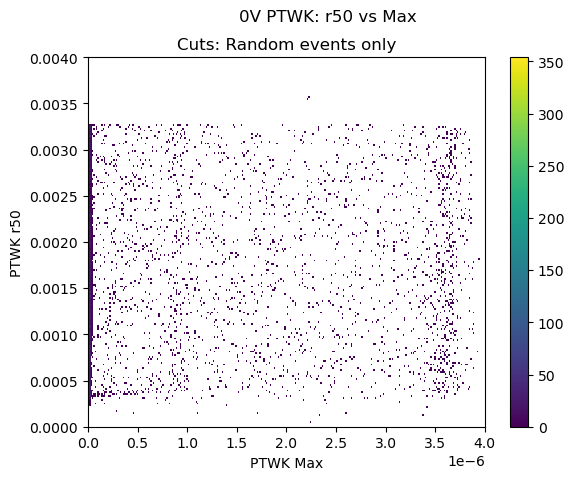

In [54]:
fig = plt.figure()
h = plt.hist2d(z[0]["PTWKmax"][crand[0]],z[0]["PTWKr50"][crand[0]],
           bins=(np.linspace(0,4e-6,300),np.linspace(0,0.004,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.xlabel("PTWK Max"); plt.ylabel("PTWK r50")
plt.title("Cuts: Random events only")
plt.suptitle(lab[0]+" PTWK: r50 vs Max")
plt.show()

In [56]:
print("Random events in",lab[0],"data:", len(crand[0][crand[0]]))
print("Random events in",lab[0],"with PTWK max above 5e-7 and PTWK r50 between 5e-4 and 3e-3:", len(crand[0][crand[0] & (z[0]["PTWKmax"] > 0.5e-6) & (z[0]["PTWKr50"]>0.0005) & (z[0]["PTWKr50"] < 0.003)]))
twindow = 0.003-0.0005
rate_rand = math.log(15345/(15345-1727))/twindow
print("Rate of random events in",lab[0],"(Hz):",rate_rand)
print("Non-random events in",lab[0],"beyond 60kth with PTWK max above 5e-7: ",len(crand[0][~crand[0] & ctime0[0] & (z[0]["PTWKmax"]>0.5e-6)]))
rate_trig = 78339/timesec[0]
print("Trigger rate in",lab[0],"(Hz):",rate_trig)
effic_write = rate_trig/rate_rand
print("Write efficiency for",lab[0]+":",effic_write)

Random events in 0V data: 15345
Random events in 0V with PTWK max above 5e-7 and PTWK r50 between 5e-4 and 3e-3: 1727
Rate of random events in 0V (Hz): 47.75889640436981
Non-random events in 0V beyond 60kth with PTWK max above 5e-7:  78339
Trigger rate in 0V (Hz): 41.5812101910828
Write efficiency for 0V: 0.8706484722556997


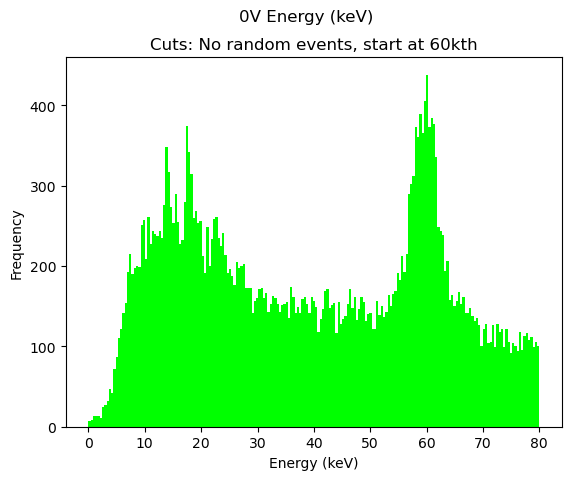

In [57]:
plt.hist(pt_keV[0][~crand[0] & ctime0[0]],bins=np.linspace(0,80,200),color='lime')
plt.xlabel("Energy (keV)"); plt.ylabel("Frequency")
plt.title("Cuts: No random events, start at 60kth")
plt.suptitle(lab[0]+" Energy (keV)")
plt.show()

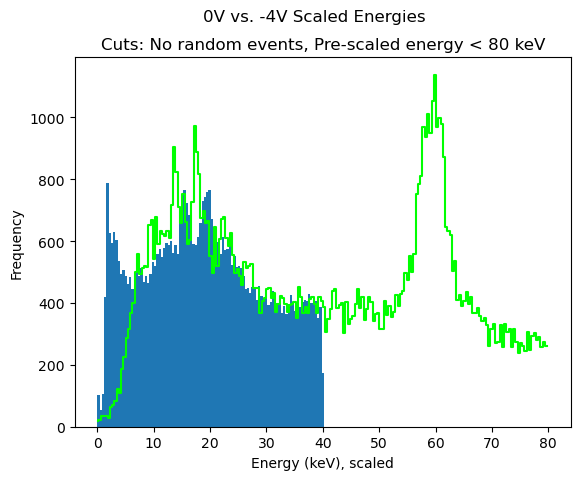

In [60]:
pt_keV[1] = 7.738820e+07*z[1]["PTOFamps"] + 1.653756e+13*z[1]["PTOFamps"]**2

plt.step((h0[1][:-1]+h0[1][1:])/2,h0[0]*timesec[1]/timesec[0],color='lime')
h1 = plt.hist(pt_keV[1][~crand[1] & (pt_keV[1]<80)]/2.,bins=np.linspace(0,80,200))

plt.suptitle(lab[0]+" vs. "+lab[1]+" Scaled Energies")
plt.title("Cuts: No random events, Pre-scaled energy < 80 keV")
plt.xlabel("Energy (keV), scaled"); plt.ylabel("Frequency")
plt.show()

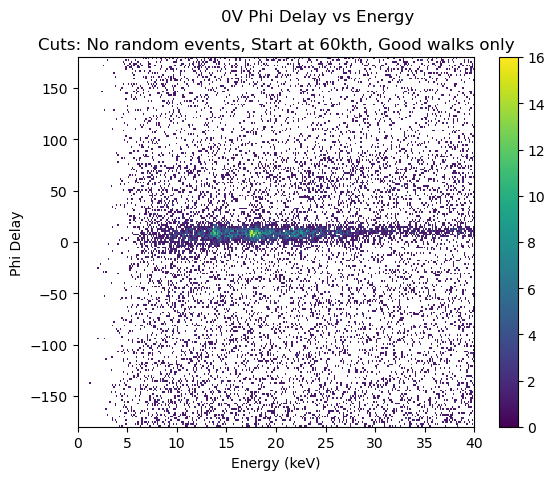

In [62]:
fig = plt.figure()
h = plt.hist2d(pt_keV[0][~crand[0] & ctime0[0] & cgoodwalk[0]],z[0]["phidel"][~crand[0] & ctime0[0] & cgoodwalk[0]],
           bins=(np.linspace(0,40,300),np.linspace(-180,180,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.xlabel("Energy (keV)"); plt.ylabel("Phi Delay")
plt.title("Cuts: No random events, Start at 60kth, Good walks only")
plt.suptitle(lab[0]+" Phi Delay vs Energy")
plt.show()

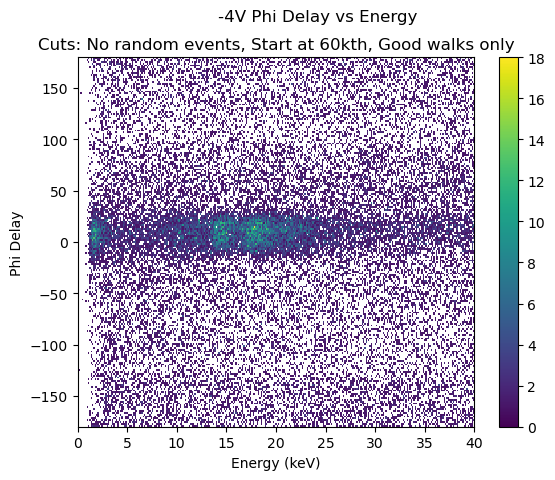

In [63]:
fig = plt.figure()
h = plt.hist2d(pt_keV[1][~crand[1] & cgoodwalk[1]]/2.15,z[1]["phidel"][~crand[1] & cgoodwalk[1]],
           bins=(np.linspace(0,40,300),np.linspace(-180,180,200)),cmap=cmap,vmin=1e-10)
fig.colorbar(h[3])
plt.xlabel("Energy (keV)"); plt.ylabel("Phi Delay")
plt.title("Cuts: No random events, Start at 60kth, Good walks only")
plt.suptitle(lab[1]+" Phi Delay vs Energy")
plt.show()

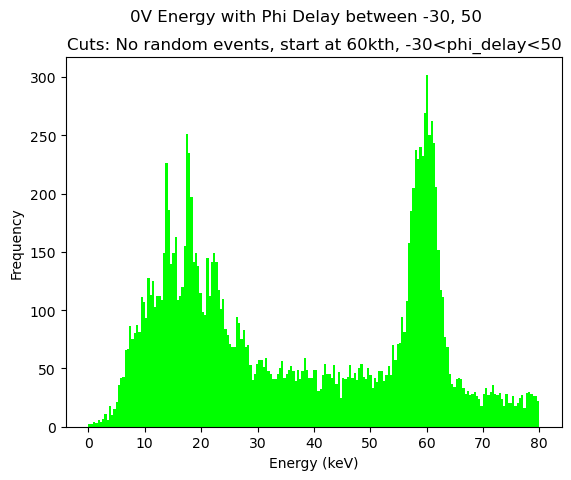

In [64]:
camphi = []
for x in z:
    camphi.append((x["phidel"]>-30) & (x["phidel"]<50))

h0am = plt.hist(pt_keV[0][~crand[0] & ctime0[0] & camphi[0]],bins=np.linspace(0,80,200),color='lime')

plt.xlabel("Energy (keV)"); plt.ylabel("Frequency")
plt.title("Cuts: No random events, start at 60kth, -30<phi_delay<50")
plt.suptitle(lab[0]+" Energy with Phi Delay between -30, 50")

plt.show()

At this point, I've stopped frequently encountering issues -- so I think I have the hang of things. No need to continue replicating <i>everything</i>; we should move on to trying out cdmsbats.